##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# MoveNet: Ultra fast and accurate pose detection model.

## Visualization libraries & Imports

!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [54]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import time
import os
import re


# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

# Some modules to preprocess images
from lib.utils import rotate

In [3]:
# !pip install -q imageio
# !pip install -q opencv-python

In [4]:
# @title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    "nose": 0,
    "left_eye": 1,
    "right_eye": 2,
    "left_ear": 3,
    "right_ear": 4,
    "left_shoulder": 5,
    "right_shoulder": 6,
    "left_elbow": 7,
    "right_elbow": 8,
    "left_wrist": 9,
    "right_wrist": 10,
    "left_hip": 11,
    "right_hip": 12,
    "left_knee": 13,
    "right_knee": 14,
    "left_ankle": 15,
    "right_ankle": 16,
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): "m",
    (0, 2): "c",
    (1, 3): "m",
    (2, 4): "c",
    (0, 5): "m",
    (0, 6): "c",
    (5, 7): "m",
    (7, 9): "m",
    (6, 8): "c",
    (8, 10): "c",
    (5, 6): "y",
    (5, 11): "m",
    (6, 12): "c",
    (11, 12): "y",
    (11, 13): "m",
    (13, 15): "m",
    (12, 14): "c",
    (14, 16): "c",
}


def _keypoints_and_edges_for_display(
    keypoints_with_scores, height, width, keypoint_threshold=0.11
):
    """Returns high confidence keypoints and edges for visualization.

    Args:
      keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
        the keypoint coordinates and scores returned from the MoveNet model.
      height: height of the image in pixels.
      width: width of the image in pixels.
      keypoint_threshold: minimum confidence score for a keypoint to be
        visualized.

    Returns:
      A (keypoints_xy, edges_xy, edge_colors) containing:
        * the coordinates of all keypoints of all detected entities;
        * the coordinates of all skeleton edges of all detected entities;
        * the colors in which the edges should be plotted.
    """
    keypoints_all = []
    keypoint_edges_all = []
    edge_colors = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    for idx in range(num_instances):
        kpts_x = keypoints_with_scores[0, idx, :, 1]
        kpts_y = keypoints_with_scores[0, idx, :, 0]
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        kpts_absolute_xy = np.stack(
            [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1
        )
        kpts_above_thresh_absolute = kpts_absolute_xy[
            kpts_scores > keypoint_threshold, :
        ]
        keypoints_all.append(kpts_above_thresh_absolute)

        for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
            if (
                kpts_scores[edge_pair[0]] > keypoint_threshold
                and kpts_scores[edge_pair[1]] > keypoint_threshold
            ):
                x_start = kpts_absolute_xy[edge_pair[0], 0]
                y_start = kpts_absolute_xy[edge_pair[0], 1]
                x_end = kpts_absolute_xy[edge_pair[1], 0]
                y_end = kpts_absolute_xy[edge_pair[1], 1]
                line_seg = np.array([[x_start, y_start], [x_end, y_end]])
                keypoint_edges_all.append(line_seg)
                edge_colors.append(color)
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all, axis=0)
    else:
        keypoints_xy = np.zeros((0, 17, 2))

    if keypoint_edges_all:
        edges_xy = np.stack(keypoint_edges_all, axis=0)
    else:
        edges_xy = np.zeros((0, 2, 2))
    return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image,
    keypoints_with_scores,
    crop_region=None,
    close_figure=False,
    output_image_height=None,
):
    """Draws the keypoint predictions on image.

    Args:
      image: A numpy array with shape [height, width, channel] representing the
        pixel values of the input image.
      keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
        the keypoint coordinates and scores returned from the MoveNet model.
      crop_region: A dictionary that defines the coordinates of the bounding box
        of the crop region in normalized coordinates (see the init_crop_region
        function below for more detail). If provided, this function will also
        draw the bounding box on the image.
      output_image_height: An integer indicating the height of the output image.
        Note that the image aspect ratio will be the same as the input image.

    Returns:
      A numpy array with shape [out_height, out_width, channel] representing the
      image overlaid with keypoint predictions.
    """
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    # To remove the huge white borders
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis("off")

    im = ax.imshow(image)
    line_segments = LineCollection([], linewidths=(4), linestyle="solid")
    ax.add_collection(line_segments)
    # Turn off tick labels
    scat = ax.scatter([], [], s=60, color="#FF1493", zorder=3)

    (keypoint_locs, keypoint_edges, edge_colors) = _keypoints_and_edges_for_display(
        keypoints_with_scores, height, width
    )

    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
    if keypoint_edges.shape[0]:
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
    if keypoint_locs.shape[0]:
        scat.set_offsets(keypoint_locs)

    if crop_region is not None:
        xmin = max(crop_region["x_min"] * width, 0.0)
        ymin = max(crop_region["y_min"] * height, 0.0)
        rec_width = min(crop_region["x_max"], 0.99) * width - xmin
        rec_height = min(crop_region["y_max"], 0.99) * height - ymin
        rect = patches.Rectangle(
            (xmin, ymin),
            rec_width,
            rec_height,
            linewidth=1,
            edgecolor="b",
            facecolor="none",
        )
        ax.add_patch(rect)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,)
    )
    plt.close(fig)
    if output_image_height is not None:
        output_image_width = int(output_image_height / height * width)
        image_from_plot = cv2.resize(
            image_from_plot,
            dsize=(output_image_width, output_image_height),
            interpolation=cv2.INTER_CUBIC,
        )
    return image_from_plot


def to_gif(images, fps):
    """Converts image sequence (4D numpy array) to gif."""
    imageio.mimsave("./animation.gif", images, fps=fps)
    return embed.embed_file("./animation.gif")


def progress(value, max=100):
    return HTML(
        """
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(
            value=value, max=max
        )
    )

## Load Model from TF hub

In [5]:
import sys

if sys.platform == "linux":
    physical_devices = tf.config.experimental.list_physical_devices("GPU")
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-11-22 18:03:00.079189: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-22 18:03:01.049956: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-11-22 18:03:01.050030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: andrew-Aspire-A715-41G
2021-11-22 18:03:01.050043: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: andrew-Aspire-A715-41G
2021-11-22 18:03:01.050336: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.82.0
2021-11-22 18:03:01.050382: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.82.0
2021-11-22 18:03:01.050394: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.82.0


In [6]:
model_name = "movenet_lightning"  # @param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite",
# "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
    if "movenet_lightning_f16" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
        input_size = 192
    elif "movenet_thunder_f16" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
        input_size = 256
    elif "movenet_lightning_int8" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
        input_size = 192
    elif "movenet_thunder_int8" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
        input_size = 256
    else:
        raise ValueError("Unsupported model name: %s" % model_name)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_path="model.tflite")
    interpreter.allocate_tensors()

    def movenet(input_image):
        """Runs detection on an input image.

        Args:
          input_image: A [1, height, width, 3] tensor represents the input image
            pixels. Note that the height/width should already be resized and match the
            expected input resolution of the model before passing into this function.

        Returns:
          A [1, 1, 17, 3] float numpy array representing the predicted keypoint
          coordinates and scores.
        """
        # TF Lite format expects tensor type of uint8.
        input_image = tf.cast(input_image, dtype=tf.uint8)
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        interpreter.set_tensor(input_details[0]["index"], input_image.numpy())
        # Invoke inference.
        interpreter.invoke()
        # Get the model prediction.
        keypoints_with_scores = interpreter.get_tensor(output_details[0]["index"])
        return keypoints_with_scores


else:
    if "movenet_lightning" in model_name:
        module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
        input_size = 192
    elif "movenet_thunder" in model_name:
        module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
        input_size = 256
    else:
        raise ValueError("Unsupported model name: %s" % model_name)

    def movenet(input_image):
        """Runs detection on an input image.

        Args:
          input_image: A [1, height, width, 3] tensor represents the input image
            pixels. Note that the height/width should already be resized and match the
            expected input resolution of the model before passing into this function.

        Returns:
          A [1, 1, 17, 3] float numpy array representing the predicted keypoint
          coordinates and scores.
        """
        model = module.signatures["serving_default"]

        # SavedModel format expects tensor type of int32.
        input_image = tf.cast(input_image, dtype=tf.int32)
        # Run model inference.
        outputs = model(input_image)
        # Output is a [1, 1, 17, 3] tensor.
        keypoint_with_scores = outputs["output_0"].numpy()
        return keypoint_with_scores

2021-11-22 18:03:05.133688: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-22 18:03:05.166507: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2295785000 Hz
2021-11-22 18:03:05.167480: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2387400 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-22 18:03:05.167512: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


## Video keypoints extraction

This section demonstrates how to apply intelligent cropping based on detections from the previous frame when the input is a sequence of frames. This allows the model to devote its attention and resources to the main subject, resulting in much better prediction quality without sacrificing the speed.


In [7]:
# @title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2


def init_crop_region(image_height, image_width):
    """Defines the default crop region.

    The function provides the initial crop region (pads the full image from both
    sides to make it a square image) when the algorithm cannot reliably determine
    the crop region from the previous frame.
    """
    if image_width > image_height:
        box_height = image_width / image_height
        box_width = 1.0
        y_min = (image_height / 2 - image_width / 2) / image_height
        x_min = 0.0
    else:
        box_height = 1.0
        box_width = image_height / image_width
        y_min = 0.0
        x_min = (image_width / 2 - image_height / 2) / image_width

    return {
        "y_min": y_min,
        "x_min": x_min,
        "y_max": y_min + box_height,
        "x_max": x_min + box_width,
        "height": box_height,
        "width": box_width,
    }


def torso_visible(keypoints):
    """Checks whether there are enough torso keypoints.

    This function checks whether the model is confident at predicting one of the
    shoulders/hips which is required to determine a good crop region.
    """
    return (
        keypoints[0, 0, KEYPOINT_DICT["left_hip"], 2] > MIN_CROP_KEYPOINT_SCORE
        or keypoints[0, 0, KEYPOINT_DICT["right_hip"], 2] > MIN_CROP_KEYPOINT_SCORE
    ) and (
        keypoints[0, 0, KEYPOINT_DICT["left_shoulder"], 2] > MIN_CROP_KEYPOINT_SCORE
        or keypoints[0, 0, KEYPOINT_DICT["right_shoulder"], 2] > MIN_CROP_KEYPOINT_SCORE
    )


def determine_torso_and_body_range(keypoints, target_keypoints, center_y, center_x):
    """Calculates the maximum distance from each keypoints to the center location.

    The function returns the maximum distances from the two sets of keypoints:
    full 17 keypoints and 4 torso keypoints. The returned information will be
    used to determine the crop size. See determineCropRegion for more detail.
    """
    torso_joints = ["left_shoulder", "right_shoulder", "left_hip", "right_hip"]
    max_torso_yrange = 0.0
    max_torso_xrange = 0.0
    for joint in torso_joints:
        dist_y = abs(center_y - target_keypoints[joint][0])
        dist_x = abs(center_x - target_keypoints[joint][1])
        if dist_y > max_torso_yrange:
            max_torso_yrange = dist_y
        if dist_x > max_torso_xrange:
            max_torso_xrange = dist_x

    max_body_yrange = 0.0
    max_body_xrange = 0.0
    for joint in KEYPOINT_DICT.keys():
        if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
            continue
        dist_y = abs(center_y - target_keypoints[joint][0])
        dist_x = abs(center_x - target_keypoints[joint][1])
        if dist_y > max_body_yrange:
            max_body_yrange = dist_y

        if dist_x > max_body_xrange:
            max_body_xrange = dist_x

    return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]


def determine_crop_region(keypoints, image_height, image_width):
    """Determines the region to crop the image for the model to run inference on.

    The algorithm uses the detected joints from the previous frame to estimate
    the square region that encloses the full body of the target person and
    centers at the midpoint of two hip joints. The crop size is determined by
    the distances between each joints and the center point.
    When the model is not confident with the four torso joint predictions, the
    function returns a default crop which is the full image padded to square.
    """
    target_keypoints = {}
    for joint in KEYPOINT_DICT.keys():
        target_keypoints[joint] = [
            keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
            keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width,
        ]

    if torso_visible(keypoints):
        center_y = (
            target_keypoints["left_hip"][0] + target_keypoints["right_hip"][0]
        ) / 2
        center_x = (
            target_keypoints["left_hip"][1] + target_keypoints["right_hip"][1]
        ) / 2

        (
            max_torso_yrange,
            max_torso_xrange,
            max_body_yrange,
            max_body_xrange,
        ) = determine_torso_and_body_range(
            keypoints, target_keypoints, center_y, center_x
        )

        crop_length_half = np.amax(
            [
                max_torso_xrange * 1.9,
                max_torso_yrange * 1.9,
                max_body_yrange * 1.2,
                max_body_xrange * 1.2,
            ]
        )

        tmp = np.array(
            [center_x, image_width - center_x, center_y, image_height - center_y]
        )
        crop_length_half = np.amin([crop_length_half, np.amax(tmp)])

        crop_corner = [center_y - crop_length_half, center_x - crop_length_half]

        if crop_length_half > max(image_width, image_height) / 2:
            return init_crop_region(image_height, image_width)
        else:
            crop_length = crop_length_half * 2
            return {
                "y_min": crop_corner[0] / image_height,
                "x_min": crop_corner[1] / image_width,
                "y_max": (crop_corner[0] + crop_length) / image_height,
                "x_max": (crop_corner[1] + crop_length) / image_width,
                "height": (crop_corner[0] + crop_length) / image_height
                - crop_corner[0] / image_height,
                "width": (crop_corner[1] + crop_length) / image_width
                - crop_corner[1] / image_width,
            }
    else:
        return init_crop_region(image_height, image_width)


def crop_and_resize(image, crop_region, crop_size):
    """Crops and resize the image to prepare for the model input."""
    boxes = [
        [
            crop_region["y_min"],
            crop_region["x_min"],
            crop_region["y_max"],
            crop_region["x_max"],
        ]
    ]
    output_image = tf.image.crop_and_resize(
        image, box_indices=[0], boxes=boxes, crop_size=crop_size
    )
    return output_image


def run_inference(movenet, image, crop_region, crop_size):
    """Runs model inferece on the cropped region.

    The function runs the model inference on the cropped region and updates the
    model output to the original image coordinate system.
    """
    image_height, image_width, _ = image.shape
    input_image = crop_and_resize(
        tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size
    )
    # Run model inference.
    keypoints_with_scores = movenet(input_image)
    # Update the coordinates.
    for idx in range(17):
        keypoints_with_scores[0, 0, idx, 0] = (
            crop_region["y_min"] * image_height
            + crop_region["height"] * image_height * keypoints_with_scores[0, 0, idx, 0]
        ) / image_height
        keypoints_with_scores[0, 0, idx, 1] = (
            crop_region["x_min"] * image_width
            + crop_region["width"] * image_width * keypoints_with_scores[0, 0, idx, 1]
        ) / image_width
    return keypoints_with_scores

### Load videos, extract keypoints and save to *.npy files

In [41]:
# Load the input image.
names = [
    "id0_jab_1",
    "id0_jab_2",
    "id0_hook_1",
    "id0_hook_2",
    "id0_uper_1",
    "id0_uper_2",
    "id1_jab_1",
    "id1_jab_2",
    "id1_hook_1",
    "id1_hook_2",
    "id1_uper_1",
    "id1_uper_2",
]

for name in names:
    print(f"Start {name}")

    video_path = f"./data/video/{name}.mp4"
    cap = cv2.VideoCapture(video_path)
    keypoints = []
    i = 0
    
    flip_image = np.random.rand() > 0.5
    if flip_image:
        print(f"{name} has been flipped!")

    ret, frame = cap.read()
    frame = rotate(frame, 90)
    image_height, image_width, _ = frame.shape
    crop_region = init_crop_region(image_height, image_width)


    while cap.isOpened():
        if flip_image:
            frame = cv2.flip(frame, 1)

        keypoints_with_scores = run_inference(
            movenet, frame, crop_region, crop_size=[input_size, input_size]
        )
        keypoints.append(keypoints_with_scores)

        crop_region = determine_crop_region(
            keypoints_with_scores, image_height, image_width
        )

        ret, frame = cap.read()

        if not ret:
            break
            
        frame = rotate(frame, 90)
        i += 1

    cap.release()

    np.save(name, np.array(keypoints))
    print(f"Done {name}, {i} frames")

Start id0_jab_1
id0_jab_1 has been flipped!
Done id0_jab_1, 951 frames
Start id0_jab_2
id0_jab_2 has been flipped!
Done id0_jab_2, 992 frames
Start id0_hook_1
id0_hook_1 has been flipped!
Done id0_hook_1, 1099 frames
Start id0_hook_2
Done id0_hook_2, 1050 frames
Start id0_uper_1
Done id0_uper_1, 1199 frames
Start id0_uper_2
id0_uper_2 has been flipped!
Done id0_uper_2, 1185 frames
Start id1_jab_1
id1_jab_1 has been flipped!
Done id1_jab_1, 801 frames
Start id1_jab_2
Done id1_jab_2, 642 frames
Start id1_hook_1
id1_hook_1 has been flipped!
Done id1_hook_1, 857 frames
Start id1_hook_2
id1_hook_2 has been flipped!
Done id1_hook_2, 791 frames
Start id1_uper_1
Done id1_uper_1, 745 frames
Start id1_uper_2
Done id1_uper_2, 702 frames


## P.S. Check frames

In [42]:
name = "id0_jab_1"

In [43]:
keypoints = np.load(f"./data/keypoints/{name}.npy")

In [44]:
keypoints.shape

(952, 1, 1, 17, 3)

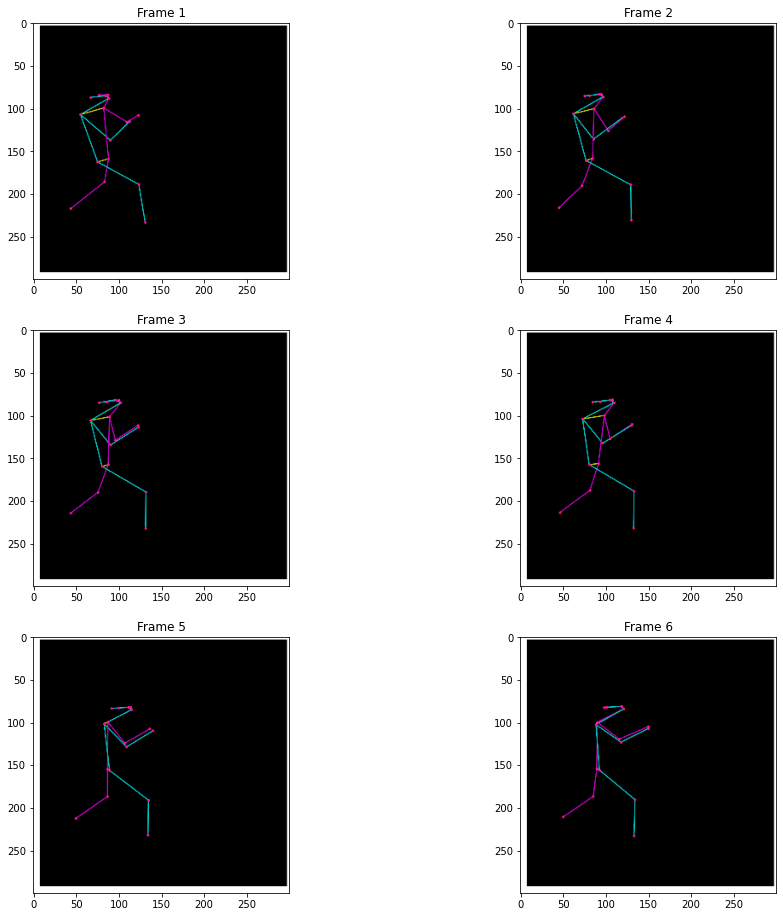

In [45]:
start, N = 0, 6
plt.figure(figsize=(16, 16))

for i in range(N):
    dump = draw_prediction_on_image(
        np.zeros((300, 300, 3)),
        keypoints[start + i],
        crop_region=None,
        close_figure=True,
        output_image_height=300,
    )
    plt.subplot(N // 2, 2, i + 1)
    plt.title(f"Frame {i + 1}")
    plt.imshow(dump)

In [46]:
cap = cv2.VideoCapture(f"./data/video/{name}.mp4")

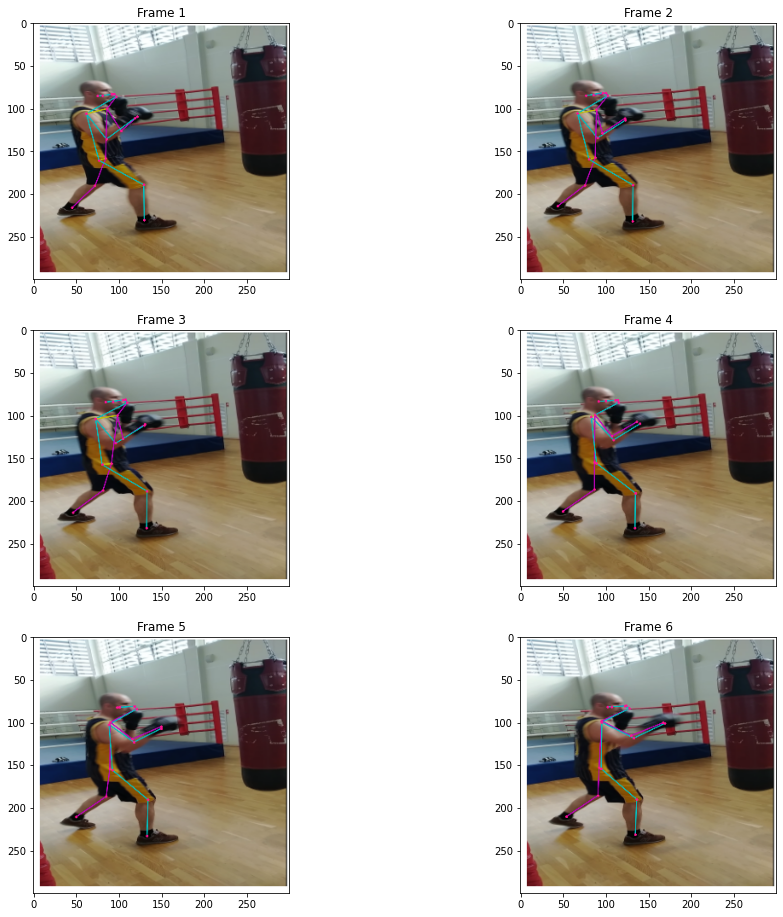

In [47]:
frame_num, N = 0, 6
plt.figure(figsize=(16, 16))

while frame_num != N:
    ret, frame = cap.read()
    frame = frame[:, :, ::-1]
    frame = cv2.resize(frame, (300, 300), interpolation=cv2.INTER_AREA)
    frame = rotate(frame, 90)
    # video has been flipped
    frame = cv2.flip(frame, 1)
    dump = draw_prediction_on_image(
        frame,
        keypoints[frame_num + 1],
        crop_region=None,
        close_figure=True,
        output_image_height=300,
    )

    plt.subplot(N // 2, 2, frame_num + 1)
    plt.title(f"Frame {frame_num + 1}")
    plt.imshow(dump)

    frame_num = frame_num + 1

# Prepare gif visualization.
output = np.stack(output_images, axis=0)
to_gif(output, fps=24)


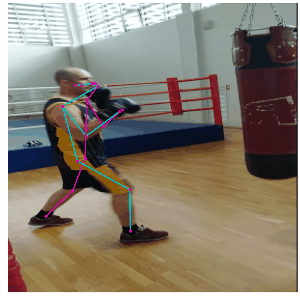

<Figure size 1152x1152 with 0 Axes>

In [48]:
cap = cv2.VideoCapture(f"./data/video/{name}.mp4")
output_frames = []

frame_num, N = 0, 24
plt.figure(figsize=(16, 16))

while frame_num != N:
    ret, frame = cap.read()
    frame = frame[:, :, ::-1]
    frame = cv2.resize(frame, (300, 300), interpolation=cv2.INTER_AREA)
    frame = rotate(frame, 90)
    # video has been flipped
    frame = cv2.flip(frame, 1)
    dump = draw_prediction_on_image(
        frame,
        keypoints[frame_num + 1],
        crop_region=None,
        close_figure=True,
        output_image_height=300,
    )

    output_frames.append(dump)
    frame_num = frame_num + 1

output = np.stack(output_frames, axis=0)
to_gif(output, fps=10)

## P.S. Check labels

In [49]:
# utils
def get_frame_num(labels):
    frame_num = 0
    frame_num_list = re.findall(r"\d+", labels[0])

    if len(frame_num_list) != 0 and int(frame_num_list[0]) != 1:
        frame_num = int(re.findall(r"\d+", labels[0])[0])
    else:
        frame_num = max(*re.findall(r"\d+", " ".join(labels)))

    return int(frame_num)

In [52]:
files = os.listdir('data/labels/')
files

['id1_hook_2',
 'id0_jab_1',
 'id0_uper_2',
 'id0_jab_2',
 'id1_hook_1',
 'id0_uper_1',
 'id0_hook_2',
 'id1_jab_1',
 'id0_hook_1',
 'id1_jab_2',
 'id1_uper_1',
 'id1_uper_2']

In [55]:
puch_data_dict = {}

for f in files:
    with open(f"data/labels/{f}") as file:
        labels = file.readlines()

    N = get_frame_num(labels)
    y = np.zeros(N, dtype=int)

    for lab in labels:
        C = re.findall(r"\d:", lab)

        if len(C) == 0:
            continue

        if len(C) == 1:
            C = int(C[0][0])

        idxs = re.findall(r"\d+-\d+", lab)
        for idx in idxs:
            start, stop = idx.split("-")
            y[int(start) : int(stop)] = C

    puch_data_dict[str(f)] = {"y": y}

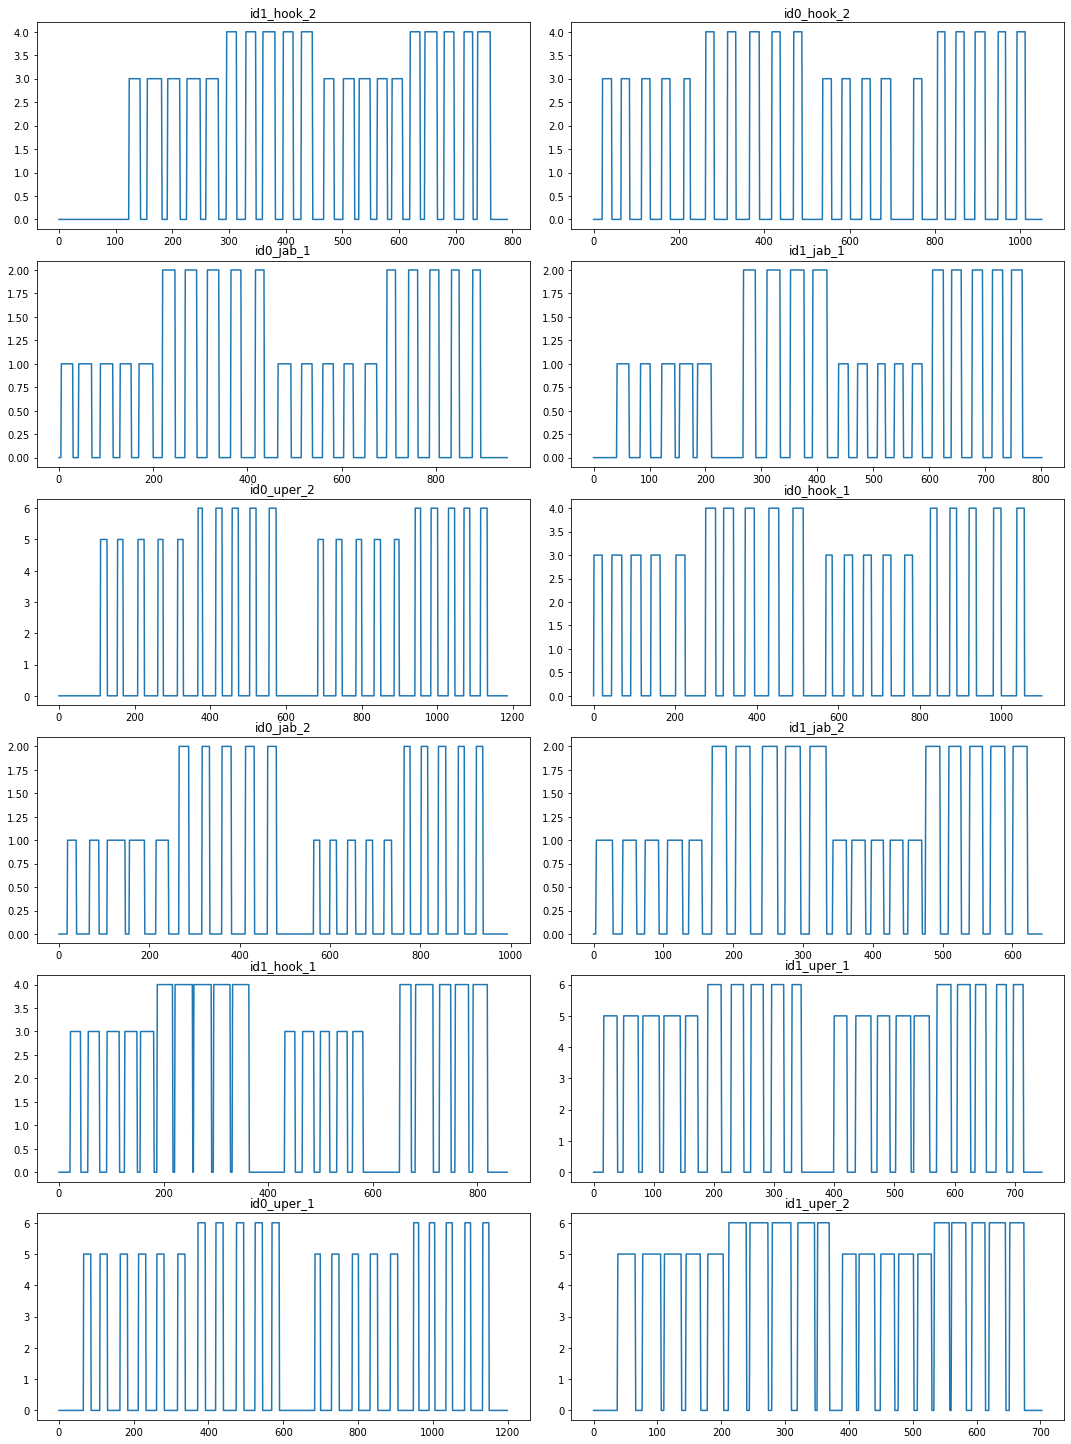

In [56]:
fig, ax = plt.subplots(len(files) // 2, 2, figsize=(15, 20))
fig.tight_layout()

for i in range(2):
    for j in range(len(files) // 2):
        file_name = files[i * 6 + j]
        data = puch_data_dict.get(file_name)
        ax[j, i].plot(data.get("y"))
        ax[j, i].set_title(file_name)